In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys

sys.path.append("../")

In [2]:
import torch
import numpy as np
from common import data_preprocess
from common.dataloader import load_dataset
from common.batching import TokenDataset
from common.utils import seed_everything, pprint
from networks.cmanomaly import CMAnomaly
from common.evaluation import evaluator
from common.vocab import Vocab
from matplotlib import pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

In [25]:
dataset = "SMD"
subdataset = "machine-1-5"
normalize = "minmax"
save_path = "./savd_dir"
batch_size = 64
device = 0  # -1 for cpu, 0 for cuda:0
window_size = 65
stride = 1
nb_epoch = 60
patience = 5

lr = 0.01
hidden_size = 64
num_layers = 1
dropout = 0
embedding_dim = 1
prediction_length = 1
prediction_dims = []
iterate_threshold = True
point_adjustment = True

In [4]:
est = KBinsDiscretizer(
            n_bins=10, encode="ordinal", strategy="kmeans"
        )
train_tokens = est.fit_transform(data_dict["train"])
test_tokens = est.transform(data_dict["test"])

NameError: name 'data_dict' is not defined

In [26]:
data_dict = load_dataset(
    dataset,
    subdataset,
)

pp = data_preprocess.preprocessor()
# data_dict = pp.normalize(data_dict, method=normalize)

### make symbols and convert to numerical features
data_dict1 = pp.symbolize(data_dict, n_bins=5, strategy="uniform")

print(data_dict1["train_tokens"])
vocab = Vocab()
vocab.build_vocab(data_dict1)
data_dict2 = vocab.transform(data_dict1)
### end

.././datasets/anomaly/SMD/processed/machine-1-5_train.pkl
Shape of train is (23705, 38).
Shape of test is (23706, 38).
Shape of test_labels is (23706,).
Discarding constant dimensions.
Convert time series to symbolics.
[['0.0_0' '0.0_1' '0.0_2' ... '0.0_27' '0.0_28' '0.0_29']
 ['0.0_0' '0.0_1' '0.0_2' ... '0.0_27' '0.0_28' '0.0_29']
 ['0.0_0' '0.0_1' '0.0_2' ... '0.0_27' '0.0_28' '0.0_29']
 ...
 ['0.0_0' '0.0_1' '0.0_2' ... '0.0_27' '0.0_28' '0.0_29']
 ['1.0_0' '0.0_1' '0.0_2' ... '0.0_27' '1.0_28' '1.0_29']
 ['0.0_0' '0.0_1' '0.0_2' ... '0.0_27' '0.0_28' '0.0_29']]
Vocab size: 144
{'0.0_0': 1, '0.0_1': 2, '0.0_10': 3, '0.0_11': 4, '0.0_12': 5, '0.0_13': 6, '0.0_14': 7, '0.0_15': 8, '0.0_16': 9, '0.0_17': 10, '0.0_18': 11, '0.0_19': 12, '0.0_2': 13, '0.0_20': 14, '0.0_21': 15, '0.0_22': 16, '0.0_23': 17, '0.0_24': 18, '0.0_25': 19, '0.0_26': 20, '0.0_27': 21, '0.0_28': 22, '0.0_29': 23, '0.0_3': 24, '0.0_4': 25, '0.0_5': 26, '0.0_6': 27, '0.0_7': 28, '0.0_8': 29, '0.0_9': 30, '1.0_0': 

In [15]:
np.unique(data_dict1["train_tokens"][:, 0])

array(['0.0_0', '1.0_0', '2.0_0', '3.0_0', '4.0_0'], dtype='<U35')

In [27]:
np.unique(data_dict2["train"][:, 0]), np.unique(data_dict2["test_labels"])

(array([  1,  31,  60,  89, 114]), array([0., 1.], dtype=float32))

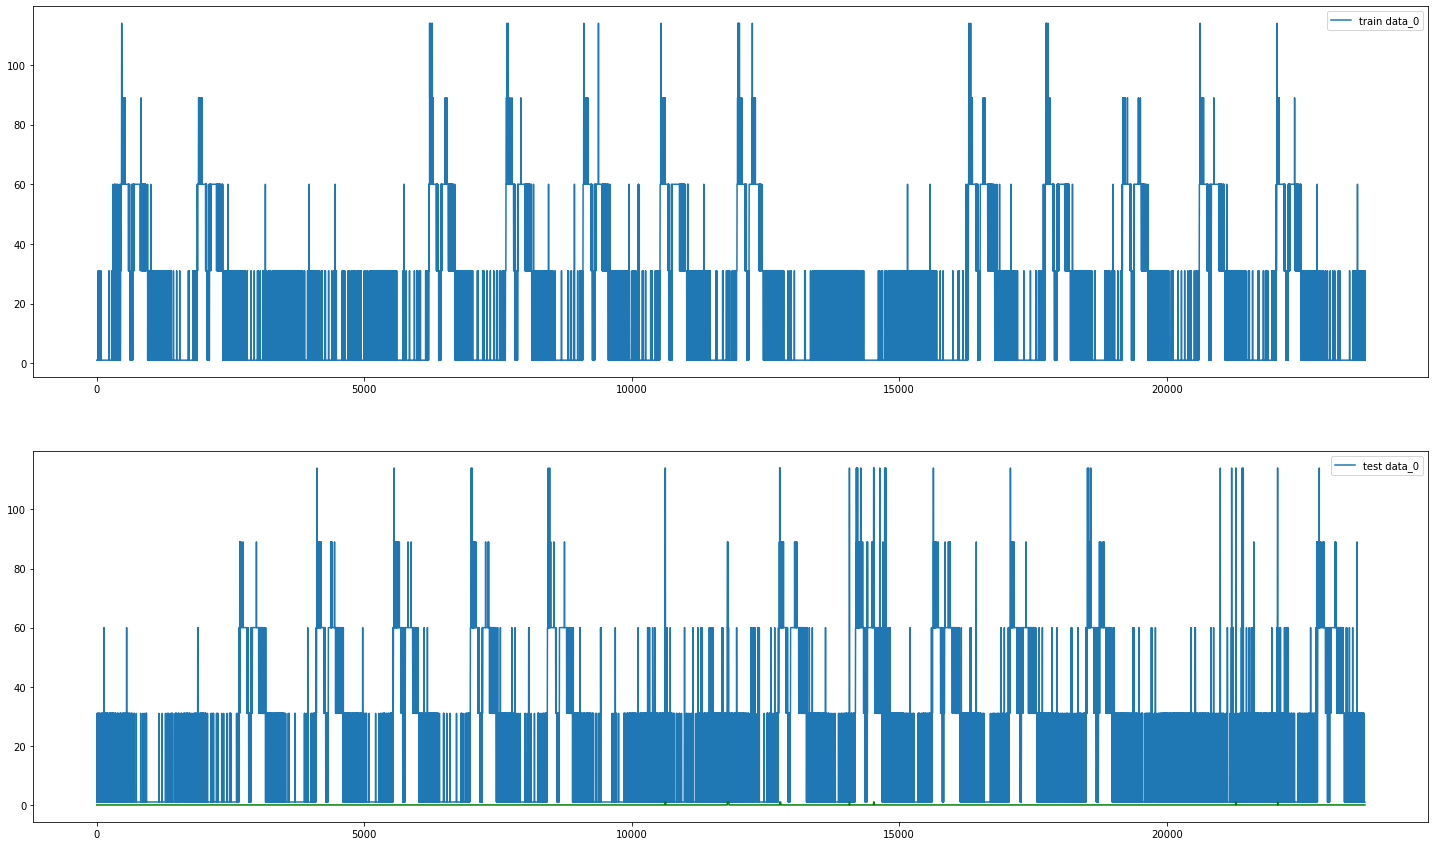

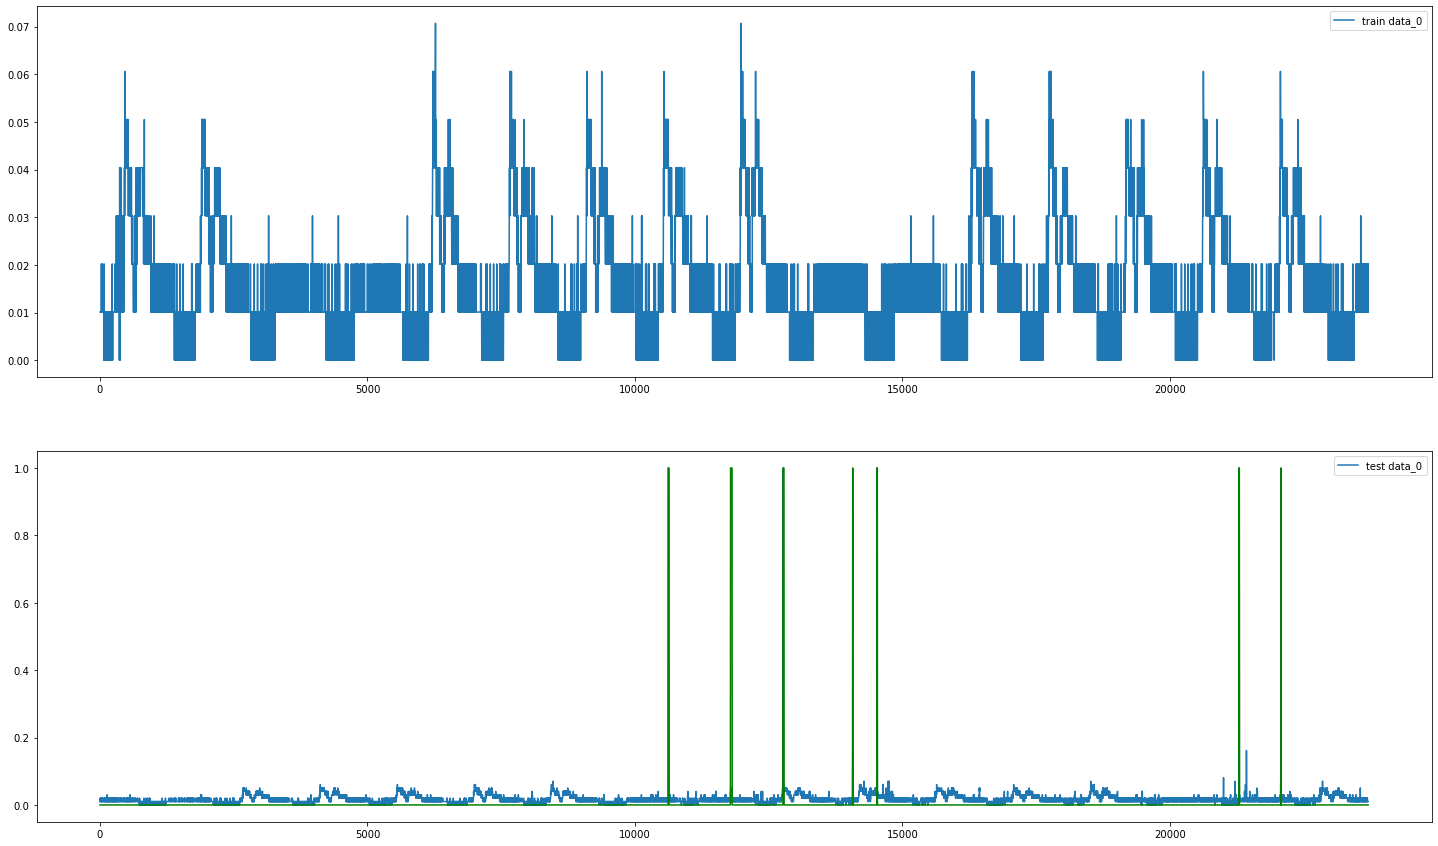

In [9]:
def plot_mts_data(data_dict, dims=[]):
    train_data = data_dict["train"]
    test_data = data_dict["test"]
    label =  data_dict["test_labels"]
    if not dims:
        dims = range(test_data.shape[1])
    for dim in dims:
        fig, ax = plt.subplots(2, figsize=(25,15)) 
        ax[0].plot(train_data[:, dim], label=f"train data_{dim}")
        ax[1].plot(test_data[:, dim], label=f"test data_{dim}")
        ax[1].plot(label, c="g")
        ax[0].legend()
        ax[1].legend()
plot_mts_data(data_dict2, dims=[0])
plot_mts_data(data_dict1, dims=[0])

In [56]:
window_dict = data_preprocess.generate_windows(
    data_dict2,
    window_size=window_size,
    stride=stride,
)

train_iterator = TokenDataset(
    vocab, window_dict["train_windows"], batch_size=batch_size, shuffle=False
)
test_iterator = TokenDataset(
    vocab, window_dict["test_windows"], batch_size=512, shuffle=False
)

# print("Proceeding using {}...".format(device))

encoder = CMAnomaly(
    in_channels=data_dict2["train"].shape[1],
    window_size=window_size,
    vocab_size=vocab.vocab_size,
    embedding_dim=embedding_dim,
    dropout=dropout,
    prediction_length=prediction_length,
    prediction_dims=prediction_dims,
    patience=patience,
    save_path=save_path,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    lr=lr,
    device=device,
)

encoder.fit(
    train_iterator,
    test_iterator=test_iterator.loader,
    test_labels=window_dict["test_labels"],
)


Generating sliding windows (size 65).
Train windows #: (4729, 65, 34)
Test windows #: (23642, 65, 34)
Using device: cpu
Compiling finished.
Start training for 74 batches.
Epoch: 0, loss: 1.66469
Saving model for performance: 1.665
Saving model to ./savd_dir/CMAomaly_model.ckpt
Epoch: 1, loss: 1.01640
Saving model for performance: 1.016
Saving model to ./savd_dir/CMAomaly_model.ckpt


KeyboardInterrupt: 

In [57]:
encoder.load_encoder()
records = encoder.predict_prob(test_iterator.loader)

anomaly_score = records["score"]
anomaly_label = window_dict["test_labels"][:, -1]

eva = evaluator(
    ["auc", "f1", "pc", "rc"],
    anomaly_score,
    anomaly_label,
    iterate_threshold=iterate_threshold,
    iterate_metric="f1",
    point_adjustment=point_adjustment,
)
eval_results = eva.compute_metrics()
pprint(eval_results)

Loading model from ./savd_dir/CMAomaly_model.ckpt
Iterating threshold.
auc
	0.7328
f1
	0.6045
pc
	0.8236
raw_f1
	0.0946
raw_pc
	0.0944
raw_rc
	0.0948
rc
	0.4775


In [59]:
# loader = test_iterator.loader
loader = train_iterator.loader
encoder.eval()
with torch.no_grad():
    score_list = []
    pred_list = []
    gt_list = []
    for batch in loader:
        if not isinstance(batch, dict):
            batch = batch.to(encoder.device).float()
        return_dict = encoder(batch)
        score = (
            # average all dimension
            return_dict["score"]
            .mean(dim=-1)  # b x prediction_length
        )
        pred = return_dict["recst"]
        # mean all timestamp
        score_list.append(score)
        pred_list.append(pred)
        gt_list.append(return_dict["y"])
#         print(return_dict["x"][0, 0:], return_dict["y"][0])
pred = torch.cat(pred_list)
gt = torch.cat(gt_list)

In [58]:
import pandas as pd
pd.Series(gt.numpy().reshape(-1)).value_counts()

18    1097
21     726
17     672
20     510
19     508
16     503
13     343
15     214
14     155
dtype: int64

In [31]:
pred.shape, gt.shape

(torch.Size([4728, 30]), torch.Size([4728, 30]))

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(gt[:, 5].numpy(), pred[:, 5].numpy()), accuracy_score(gt.numpy().reshape(-1), pred.numpy().reshape(-1))

(0.24661590524534688, 0.7078398195149465)

In [33]:
gt[0:10, 0], pred[0:10, 0]

(tensor([14, 14, 14, 14, 12, 14, 12, 14, 14, 14]),
 tensor([14, 14, 12, 12, 14, 12, 14, 12, 14, 14]))

In [61]:
gt.shape

torch.Size([4728, 1])

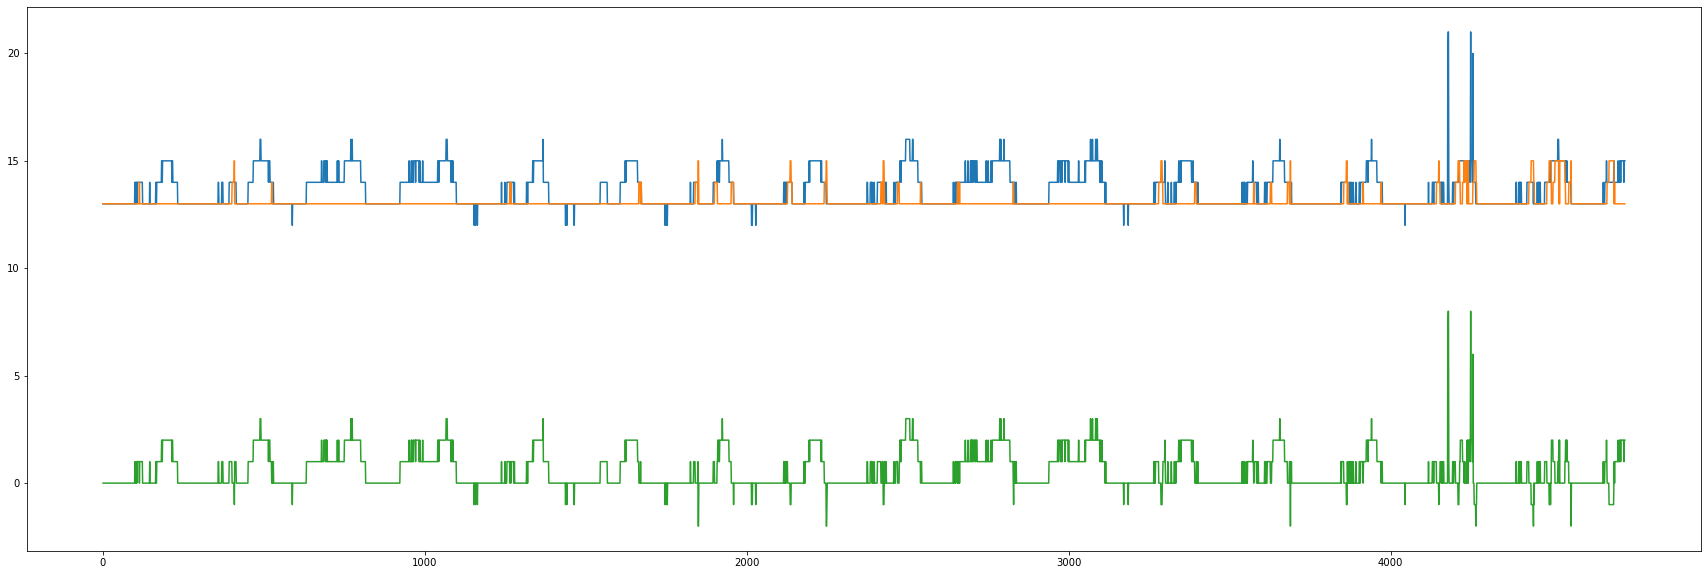

In [60]:
plt.figure(figsize=(30, 10))
plt.plot(gt[0:100000, 0])
plt.plot(pred[0:100000, 0])
plt.plot((gt-pred)[0:100000, 0])

In [14]:
gt[0:100, 0], pred[0:100, 0]

(tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 14, 14, 14, 14, 15, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 15, 14, 14, 14, 14, 15, 14, 14, 14, 14,
         15, 14, 14, 14, 14, 15, 14, 14, 14, 14, 15, 14, 14, 14, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 15, 14, 14, 14, 14, 15, 14, 14, 14, 14,
         17, 14, 14, 14, 14, 15, 14, 14, 14, 14, 15, 14, 14, 14, 14, 15, 14, 14,
         14, 14, 15, 14, 14, 14, 14, 15, 14, 14]),
 tensor([14, 14, 14, 14, 12, 14, 14, 12, 12, 14, 14, 15, 14, 14, 12, 14, 15, 14,
         14, 12, 14, 15, 14, 14, 12, 14, 15, 14, 14, 12, 14, 15, 14, 14, 12, 14,
         15, 14, 14, 12, 14, 15, 14, 14, 12, 14, 15, 14, 14, 12, 14, 14, 14, 14,
         12, 14, 14, 14, 14, 12, 14, 14, 14, 14, 12, 14, 14, 14, 14, 12, 14, 14,
         14, 14, 12, 14, 14, 14, 14, 12, 14, 14, 14, 14, 12, 14, 14, 14, 14, 12,
         14, 14, 14, 14, 12, 14, 14, 14, 14, 12]))

In [50]:
window_dict["train_windows"][0, :, 0]

array([61., 61., 61., 61., 61., 61., 61., 61., 61., 87.], dtype=float32)

In [75]:
import torch
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

In [76]:
input.shape, target.shape

(torch.Size([3, 5]), torch.Size([3]))

In [129]:
a = torch.randn(640, 26)
a.argmax(dim=-1).view()

tensor([ 7, 23, 19, 13,  4, 22,  9, 11,  3,  7,  7, 14, 22, 15,  4, 10, 20, 20,
         7,  1,  3, 19, 15, 20, 23, 13,  0, 12, 10, 22, 11, 16,  7,  7, 13, 17,
        16, 16,  2, 11, 22, 25, 13, 12,  4, 20, 12, 23,  3,  9, 17, 10, 12, 11,
         1, 14, 13, 25,  7, 25,  2, 10,  1, 10, 13, 23, 19, 21,  5, 22, 11,  7,
        19, 16,  8, 14,  2,  5,  8,  3, 10,  7,  5, 14, 18, 21, 12, 15,  7, 25,
        13,  8, 25, 14,  3, 21, 22,  8, 14, 12, 14,  2, 14,  0,  0,  7, 25, 23,
         5, 22,  2, 15, 25,  6, 11, 23,  3, 24,  8, 18, 23,  5, 20,  5, 25,  7,
        16, 12, 23, 16, 16, 16, 13, 13, 20, 19, 10, 24, 20,  0, 11, 24,  1,  7,
        15,  2,  1,  1,  9, 16,  7,  1, 23, 15,  4,  6, 19, 10,  5,  6, 15,  8,
        15, 12, 17, 22, 12,  7,  8, 12,  2, 20,  9, 14, 25, 17,  8, 13, 14,  4,
        20,  3, 13, 22, 14, 10,  7,  1, 15, 20,  6,  1, 13,  4,  7,  1, 20,  5,
        17, 14, 22, 19, 23, 13, 17, 13,  5, 23,  9, 18, 25, 17,  4, 12, 22, 12,
        14, 14,  3, 10, 16,  3, 20, 17, 